<a href="https://colab.research.google.com/github/nikita24383/Speech_emotion_recognition/blob/main/SER_sqlite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction of Individual File

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving OAF_back_angry.wav to OAF_back_angry.wav


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
audio_path = "OAF_back_angry.wav"
x, sr = librosa.load(audio_path)
print(x,sr)

[-1.0417719e-05 -1.9059131e-04 -2.8630142e-04 ...  1.6136018e-04
  1.0805293e-04  0.0000000e+00] 22050


## Zero Crossing Gate

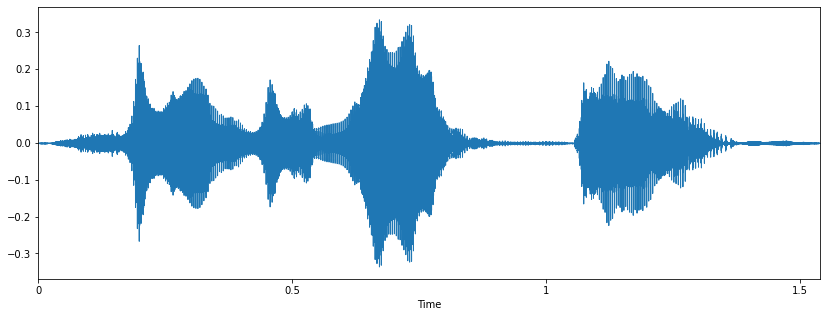

In [ ]:
# zero crossing gate
plt.figure(figsize=(14,5))
librosa.display.waveplot(x,sr=sr)

## for the amplitude at different times

[[ -0.77186096   1.1566334   -3.5512938  ...   7.213312     2.7855968
    0.12944715]
 [ -8.58168     -3.1996279   -0.73542416 ...   1.3768793   -2.4773593
   -8.345458  ]
 [-24.727839    -7.665888    -1.2120132  ...  -3.5454714  -11.230916
  -13.3662815 ]
 ...
 [-41.24357    -41.24357    -41.24357    ... -41.24357    -41.24357
  -41.24357   ]
 [-41.24357    -41.24357    -41.24357    ... -41.24357    -41.24357
  -41.24357   ]
 [-41.24357    -41.24357    -41.24357    ... -41.24357    -41.24357
  -41.24357   ]]


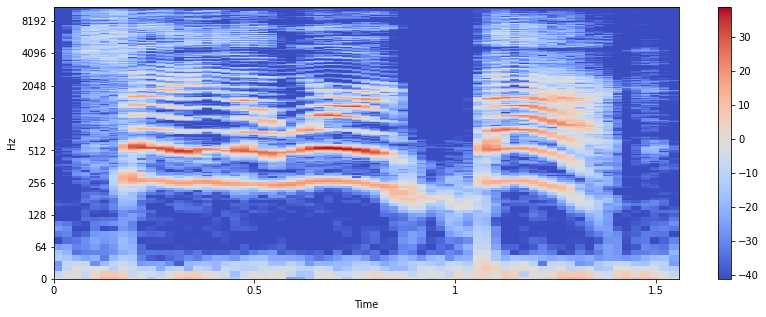

In [ ]:
# for the amplitude at different times
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
print(Xdb)
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## Zooming in

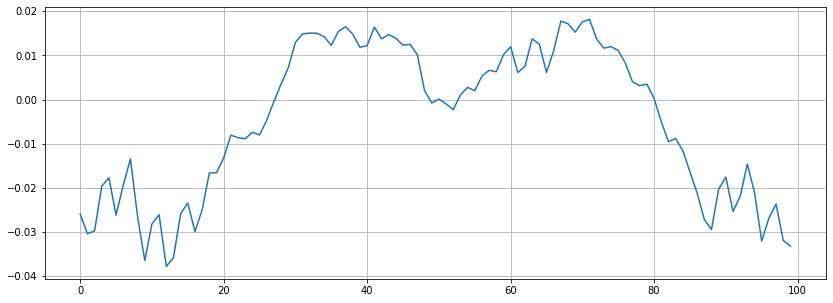

In [ ]:
# zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14,5))
plt.plot(x[n0:n1])
plt.grid()

## Zero Crossings

In [ ]:
# calculate zero crossings
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

6


## Specral Centroid

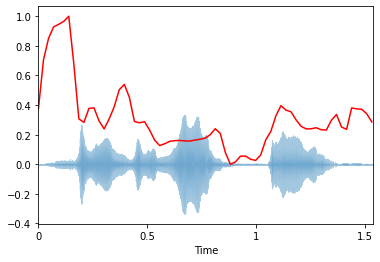

In [ ]:
# Spectral centroid
import sklearn
spectral_centroid = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroid.shape

# computing time variable for visualization
frames = range(len(spectral_centroid))
t = librosa.frames_to_time(frames)

# Normalizing for visualization
def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)

# plotting spectral central along with waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroid), color='r')

## Spectral Rolloff

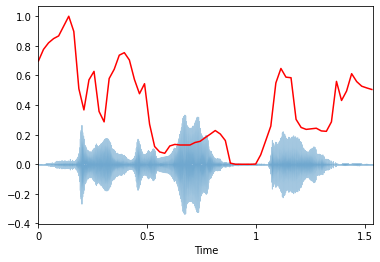

In [ ]:
# spectral rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

## MFCC

(20, 67)


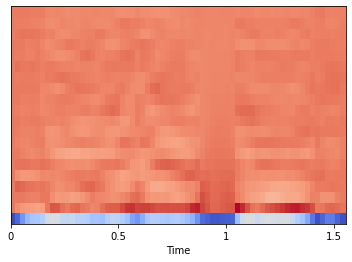

In [ ]:
# MFCC
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

# Display MFCCS
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

# Feature Extraction of Dataset

In [ ]:
import sqlite3
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Database connection

In [ ]:
database = "/content/drive/MyDrive/Colab Notebooks/SER.db"

In [ ]:
conn = sqlite3.connect(database)
print("Opened database successfully");
 
conn.execute('''
CREATE TABLE IF NOT EXISTS SER_data(filename text ,stft float, rms float, spectral_centroid float, spectral_bandwidth float, rolloff float, zero_crossing_rate float, 
                        mfcc1 float, mfcc2 float, mfcc3 float, mfcc4 float, mfcc5 float, mfcc6 float, mfcc7 float, mfcc8 float, mfcc9 float, mfcc10 float, mfcc11 float, mfcc12 float, mfcc13 float, mfcc14 float, mfcc15 float, mfcc16 float, mfcc17 float, mfcc18 float, mfcc19 float, mfcc20 float,
                        label text);''')
 
conn.commit()
 
print("Table created successfully");

Opened database successfully
Table created successfully


In [ ]:
# conn.execute("drop table SER_data");

In [ ]:
pd.read_sql_query('SELECT * from SER_data', conn)

,filename,stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,YAF_hash_angry.wav,-0.000019,0.086103,3382.018656,2165.500510,5362.740830,0.120062,-305.503418,97.868027,-66.796104,43.889774,-11.247505,3.408675,-2.609084,1.618315,0.208890,-22.834734,9.171591,-8.844200,-8.377720,2.374905,-0.597538,-3.560076,-3.265108,3.277318,-13.823437,-3.210949,angry
1,YAF_hate_ps.wav,-0.000022,0.022411,3667.081525,2448.226497,5906.268757,0.114910,-426.604706,83.908623,-48.444283,49.337677,-25.690998,-5.325626,-12.308086,-7.823286,1.809689,-19.417925,8.109517,-6.917639,-2.583233,1.693487,-2.362452,1.962945,2.339648,8.825878,-3.418119,6.265678,ps
2,YAF_hash_neutral.wav,-0.000015,0.017219,2608.889889,2169.225506,4068.537850,0.085354,-478.289246,131.853745,-37.951855,59.433270,-9.214421,13.461843,-10.396121,-0.601059,3.214530,-16.200098,15.226449,-12.741889,3.930985,-0.904938,-7.529775,10.859111,-2.773996,-2.071319,-6.594577,3.954110,neutral
3,YAF_hate_disgust.wav,-0.000009,0.020051,3254.192790,2247.544107,5211.241216,0.108102,-452.851868,101.441727,-33.893566,51.554672,0.184615,4.683600,-11.368979,-9.823822,1.756367,-16.336382,-1.010613,-10.040710,-3.146016,-1.090360,-2.702458,-0.786873,-3.308525,3.201584,-7.684624,-0.509788,disgust
4,YAF_hash_sad.wav,-0.000017,0.056314,2668.441865,2186.362125,4530.812603,0.086089,-367.962250,117.591362,-27.934797,60.024372,-3.145404,8.010200,-1.856780,0.208328,2.680925,-10.466319,15.044425,-10.982419,-4.252427,-0.689058,-7.868734,4.498769,-0.842243,-1.845163,-8.231993,1.015361,sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,OAF_pad_angry.wav,-0.000038,0.026582,2190.383528,2423.427425,4069.454000,0.048835,-458.237701,104.051727,-33.120483,19.877012,-26.585537,22.481100,-2.472189,-21.098593,4.709100,-15.027875,-0.827925,-5.938182,-3.347320,2.064474,1.527673,2.139429,0.236841,6.667533,-4.888732,-2.304507,angry
2792,OAF_note_neutral.wav,-0.000005,0.011201,1713.462752,2105.161694,2857.660560,0.041834,-577.709351,127.337410,13.825173,42.435398,-11.444418,23.861067,5.119965,-5.788062,6.106805,-13.951778,-2.290681,-7.442029,0.649184,-2.564916,-5.622483,1.622886,-0.139027,7.097710,-1.616184,0.556916,neutral
2793,OAF_note_happy.wav,0.000010,0.018545,1976.018602,2302.853916,3315.990934,0.048423,-500.941437,122.790398,10.991519,33.887783,-22.847521,16.938272,-3.523557,-6.377336,7.141045,-15.813333,-5.774833,-14.088199,-4.275845,-12.598926,-9.488898,3.915347,-3.184804,8.590802,-1.498197,-0.614682,happy
2794,OAF_note_fear.wav,0.000005,0.025693,2112.181344,2417.578093,3544.839982,0.052081,-480.033234,98.339302,-0.874960,30.393486,-25.334227,12.151534,-0.061384,-11.031945,5.379438,-15.777187,-8.036143,-13.140250,-8.644772,-9.626975,-12.204410,0.477359,-0.398135,-2.596588,-5.890542,-1.236924,fear


## Extracting Features

In [ ]:
audio_fpath = "drive/MyDrive/speech-emotion-recognition-tess-data/"
audio_clips = os.listdir(audio_fpath)
 
# iterate through the folder
for count in range(0,len(audio_clips)):
 
  print(count)
  filename = audio_clips[count]
 
  label = (audio_clips[count].split("_")[-1]).split(".")[0]
 
  x, sr = librosa.load(audio_fpath+audio_clips[count], sr=44100)
  stft = float(np.mean(librosa.stft(x)))
  rms = float(np.mean(librosa.feature.rms(x)))
  spectral_centroid = np.mean(librosa.feature.spectral_centroid(x, sr=sr))
  spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(x, sr=sr))
  rolloff = np.mean(librosa.feature.spectral_rolloff(x, sr=sr))
  zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(x))
  mfccs = (librosa.feature.mfcc(x, sr=sr))

  mfcc1, mfcc2, mfcc3, mfcc4, mfcc5, mfcc6, mfcc7, mfcc8, mfcc9, mfcc10, mfcc11, mfcc12, mfcc13, mfcc14, mfcc15, mfcc16, mfcc17, mfcc18, mfcc19, mfcc20 = [float(np.mean(i)) for i in ((mfccs))]
 
  #sql = '''INSERT INTO SER_data(  filename ,  stft ,   rms,    spectral_centroid,  spectral_bandwidth, rolloff,    zero_crossing_rate, mfcc1,  mfcc2,  mfcc3,  mfcc4,  mfcc5,  mfcc6,  mfcc7,  mfcc8,  mfcc9,  mfcc10, mfcc11, mfcc12, mfcc13, mfcc14, mfcc15, mfcc16, mfcc17, mfcc18, mfcc19, mfcc20, label)
  #sql = '''INSERT INTO SER_data VALUES( file1 , stft1 , rms1, spec_cent1, spec_bw1, rolloff1, zcr1, mfcc11, mfcc21, mfcc31, mfcc41, mfcc51, mfcc61, mfcc71, mfcc81, mfcc91, mfcc101, mfcc111, mfcc121, mfcc131, mfcc141, mfcc151, mfcc161, mfcc171, mfcc181, mfcc191, mfcc201, emotion);'''
  conn.execute("INSERT INTO SER_data (filename ,stft , rms , spectral_centroid , spectral_bandwidth , rolloff , zero_crossing_rate , mfcc1 , mfcc2 , mfcc3 , mfcc4 , mfcc5 , mfcc6 , mfcc7 , mfcc8 , mfcc9 , mfcc10 , mfcc11 , mfcc12 , mfcc13 , mfcc14 , mfcc15 , mfcc16 , mfcc17 , mfcc18 , mfcc19 , mfcc20 ,label) VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?);",(filename ,stft , rms , spectral_centroid , spectral_bandwidth , rolloff , zero_crossing_rate , mfcc1 , mfcc2 , mfcc3 , mfcc4 , mfcc5 , mfcc6 , mfcc7 , mfcc8 , mfcc9 , mfcc10 , mfcc11 , mfcc12 , mfcc13 , mfcc14 , mfcc15 , mfcc16 , mfcc17 , mfcc18 , mfcc19 , mfcc20 ,label)) 
  conn.commit()

0
YAF_hash_angry.wav


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


Streaming output truncated to the last 5000 lines.
296
YAF_match_sad.wav
297
YAF_mess_sad.wav
298
YAF_met_ps.wav
299
YAF_mess_happy.wav
300
YAF_mess_ps.wav
301
YAF_met_happy.wav
302
YAF_met_angry.wav
303
YAF_mess_disgust.wav
304
YAF_mess_neutral.wav
305
YAF_met_fear.wav
306
YAF_met_neutral.wav
307
YAF_mill_angry.wav
308
YAF_met_disgust.wav
309
YAF_mess_fear.wav
310
YAF_met_sad.wav
311
YAF_mode_angry.wav
312
YAF_mill_happy.wav
313
YAF_mob_neutral.wav
314
YAF_mob_angry.wav
315
YAF_mill_fear.wav
316
YAF_mob_happy.wav
317
YAF_mill_disgust.wav
318
YAF_mob_sad.wav
319
YAF_mob_disgust.wav
320
YAF_mill_ps.wav
321
YAF_mob_fear.wav
322
YAF_mill_sad.wav
323
YAF_mill_neutral.wav
324
YAF_mob_ps.wav
325
YAF_mode_neutral.wav
326
YAF_mood_fear.wav
327
YAF_mood_happy.wav
328
YAF_mood_angry.wav
329
YAF_mode_fear.wav
330
YAF_moon_angry.wav
331
YAF_mood_sad.wav
332
YAF_mode_disgust.wav
333
YAF_mode_happy.wav
334
YAF_mode_sad.wav
335
YAF_mood_ps.wav
336
YAF_mood_neutral.wav
337
YAF_mood_disgust.wav
338
YAF

## Preprocessing Dataset

In [ ]:
# Reading a dataset
data = pd.read_sql_query("SELECT * from SER_data", conn)
data.head()

# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)
data.head()

# encode emotions into integers
emotion_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(emotion_list)

# normalizing
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Algos

## Naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 79.82142857142858


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
KNN_y_pred = knn.predict(X_test)

from sklearn import metrics
print("KNN model accuracy(in %):", metrics.accuracy_score(y_test, KNN_y_pred)*100)

KNN model accuracy(in %): 95.71428571428572


In [ ]:
print(y_test,"    ",KNN_y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
print("confusion matrix")
confusion_matrix(y_test, y_pred)

confusion matrix


array([[59,  0,  2,  0,  0, 16,  0],
       [ 0, 77,  0, 10,  0,  1,  1],
       [ 5,  1, 62,  5,  0,  8,  0],
       [ 5,  5,  1, 41,  0, 27,  0],
       [ 0,  0,  0,  0, 61,  0,  4],
       [ 3,  8,  1,  2,  0, 71,  0],
       [ 0,  0,  0,  0, 11,  0, 73]])

In [ ]:
# Recall
print("Recall")
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average=None)

Recall


array([0.76623377, 0.86516854, 0.7654321 , 0.51898734, 0.93846154,
       0.83529412, 0.86904762])

In [ ]:
# Precision
print("Precision")
from sklearn.metrics import precision_score
precision_score(y_test, y_pred, average=None)

Precision


array([0.81944444, 0.84615385, 0.93939394, 0.70689655, 0.84722222,
       0.57723577, 0.93589744])